### Loading useful packages

In [1]:
import os, glob, gc
import itertools
import progressbar
import numpy as np
import pandas as pd
import hvplot.pandas
import seaborn as sns
import pyLPD.MLtools as mlt

from matplotlib import rcParams
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider
from sympy import symbols, sqrt, diff, lambdify
from scipy import constants, interpolate, signal, optimize

π = constants.pi
c = constants.c

%run 'cprint.py'

### Customizing plots
We used **rcParams** to set figures format.

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

<br/><br/><br/><br/>

---
# 1. Data preprocessing
---

### Fiber-MZI dispersion parameters
To build an absolute frequency ruler is necessary to make a correction considering the fiber-MZI dispersion. For this, some properties of the silica SMF-28 fiber are considered. We used the SymPy package to create symbolic equations and evaluate these for any wavelength value. The zero dispersion wavelength ($\lambda_0$) and the zero dispersion slope ($S_0$) are valid only for C-Band (1530-1565nm).

References:
- [Fiber SMF28](https://www.corning.com/media/worldwide/coc/documents/Fiber/SMF-28%20Ultra.pdf)

In [3]:
B1, B2, B3 = 0.6961663, 0.4079426, 0.8974794
C1, C2, C3 = 68.4043, 116.2414, 9896.161 # in nm

x = symbols('x')
n = sqrt(1+(B1*x**2)/(x**2-C1**2)+(B2*x**2)/(x**2-C2**2)+(B3*x**2)/(x**2-C3**2))
ng = n - x*diff(n, x)

L = 1.49e-3 # in km
print('ΔL_mzi = {0:.3} m'.format(1e3*L))

#--------------------------------
S0 = 0.082 # 0.082(3) ps/(nm².km)
Lamb0 = 1280 # 1280(40) nm

D = S0/4*(x-Lamb0**4/x**3) # in ps/(nm.km)

β1 = 1e15*(ng/c) # ps/km
D1_mzi = 1/β1/L # in THz

β2 = -1e3*(x**2/2/π/c)*D # in ps²/km
D2_mzi = -(2*π*β2/β1)*(1/β1/L)**2 # in THz

β3 = 1e6*x**3/(2*π*c)**2*(2*D+x*S0) # in ps³/km
D3_mzi = (4*π**2/L**3/β1**5)*(3*β2**2-β1*β3) # in THz

ΔL_mzi = 1.49 m


### Listing **.parq** format data
**Parquet** is a columnar storage format that allows compressing data. It is built to support very efficient compression and encoding schemes. When compared with a **.mat** format there was a reduction by around 50% in disk storage space.

In [4]:
flist = sorted(glob.glob('*.parq'), key = os.path.getmtime)
flist

['Basic-Mode-Linear-Spectrum-1460nm-1610nm_Sphere-Al2O3-120nm-pol-1_Tunics-20ms_Time_25-01-2020_00-31-32.parq',
 'Basic-Mode-Linear-Spectrum-1460nm-1610nm_Sphere-Al2O3-120nm-pol-2_Tunics-20ms_Time_25-01-2020_00-29-44.parq',
 'Basic-Mode-Linear-Spectrum-1460nm-1610nm_Sphere-Al2O3-120nm-pol-1_Tunics-20ms_Time_25-01-2020_00-31-32-Processed.parq']

### Choosing and reading raw data

In [5]:
N = 0
fname = flist[N]
print('The the name of the chosen file is: \n' + cprint.CSELECTED + fname + cprint.CEND)

data_raw = pd.read_parquet(fname)
print('Dataframe memory usage: \n' + cprint.CSELECTED + f'{round(data_raw.shape[1]*data_raw.memory_usage(index=False).mean()/1e6,2)} MB' + cprint.CEND)
data_raw.head()

The the name of the chosen file is: 
Basic-Mode-Linear-Spectrum-1460nm-1610nm_Sphere-Al2O3-120nm-pol-1_Tunics-20ms_Time_25-01-2020_00-31-32.parq
Dataframe memory usage: 
820.0 MB


time      lamb       cav       mzi       hcn
0 -5.125000  0.365709  0.601922  0.401219  0.091507
1 -5.124999  0.337029  0.603669  0.415708  0.091306
2 -5.124999  0.364171  0.608652  0.421598  0.090839
3 -5.124998  0.334677  0.602303  0.437388  0.091438
4 -5.124998  0.345533  0.607409  0.446512  0.091397

### Plotting raw data
- We use the **mzi** to choose the limit points to crop the raw data. 
- The **lambda** data is used to identify the sense of the laser wavelength.
- This script was made for **lambda growing**.

In [6]:
data_raw.hvplot.line(y=['cav'], width=1500, height=300, datashade=True, hover=False)

/home/marvyn/Documents/Miniconda3/envs/LPD/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


:DynamicMap   []
   :RGB   [index,cav]   (R,G,B,A)

### Crooping data
Crop raw data using the limit values found above. Reset data crop index and finally invert/flip it. It was made thinking about building the frequency (c/wavelength) rule.

In [7]:
if N==0:
    imin, imax = 3.343e6, 19.094e6 # Pol 1
else:
    imin, imax = 3.442e6, 19.130e6 # Pol 2

data_crop = data_raw.iloc[int(imin):int(imax),:].copy()
data_crop.reset_index(drop=True, inplace=True)
data_crop = data_crop.iloc[::-1].reset_index(drop=True)

print('Dataframe memory usage: \n' + cprint.CSELECTED + f'{round(data_crop.shape[1]*data_crop.memory_usage(index=False).mean()/1e6,2)} MB' + cprint.CEND)
data_crop.head()

Dataframe memory usage: 
630.04 MB


time      lamb       cav       mzi       hcn
0  4.422000  4.745392  0.590871  0.398731  0.073754
1  4.421999  4.759868  0.582014  0.398742  0.073637
2  4.421999  4.793795  0.589684  0.393345  0.073374
3  4.421998  4.729378  0.583548  0.385061  0.074258
4  4.421998  4.737883  0.585933  0.379791  0.073258

### Plotting cropped data

In [8]:
# data_crop.hvplot(y=['lamb','cav','mzi','hcn'], width=600, height=200, subplots=True, shared_axes=False, hover=False, datashade=True).cols(2)

### Normalizing cavity data using the uppper envelope

In [9]:
if N == 0:
    ylower, data_crop['yupper_cav'] = mlt.envPeak(data_crop.cav.values, delta=0.02,  smooth=0.004, sg_order=2)
else:
    ylower, data_crop['yupper_cav'] = mlt.envPeak(data_crop.cav.values, delta=0.03,  smooth=0.005, sg_order=0)
    
data_crop['cav_n'] = data_crop.cav/(data_crop['yupper_cav'])

# (data_crop.hvplot(y=['cav', 'yupper_cav'], width=600, height=300, hover=False, datashade=True) + data_crop.hvplot(y='cav_n', width=600, height=300, hover=False, datashade=True)).cols(2)

iterator L,R(mintab)= (0, 33)


### Normalizing MZI data using the lower and upper envelope

In [10]:
data_crop['ylower_mzi'], data_crop['yupper_mzi'] = mlt.envPeak(data_crop.mzi.values, delta=0.15, sg_order=0) # Finding lower and upper envelope
data_crop['mzi_n'] = (data_crop.mzi-data_crop['ylower_mzi'])/(data_crop['yupper_mzi']-data_crop['ylower_mzi']) # Normalizing data

# (data_crop.hvplot(y=['mzi', 'ylower_mzi', 'yupper_mzi'], width=700, height=300, hover=False, datashade=True) + data_crop.hvplot(y='mzi_n', width=700, height=300, hover=False, datashade=True)).cols(2)

iterator L,R(mintab)= (10, 64)


### Smoothing the normalized MZI using the [Savitzky Golay Filter](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5888646)

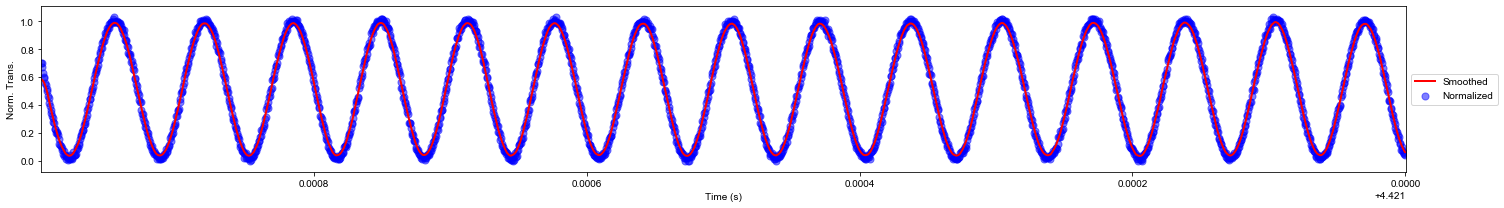

In [11]:
data_crop['mzi_s'] = mlt.savitzky_golay(data_crop.mzi_n.values, window_size = 21, order = 1)

nmax = 2e3 # Limiting plot to the 'nmax' first points

plt.figure(figsize=(21,3))
plt.scatter(data_crop.time[:int(nmax)], data_crop.mzi_n[:int(nmax)], c='b', s=50, alpha=0.5, label='Normalized')
plt.plot(data_crop.time[:int(nmax)], data_crop.mzi_s[:int(nmax)], 'r', lw=2, label='Smoothed')
plt.xlabel('Time (s)')
plt.ylabel('Norm. Trans.')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(data_crop.time[0], data_crop.time[nmax])

plt.tight_layout()
plt.show()

### Finding peaks and valleys of the smoothed MZI which are necessary for building the frequency axis

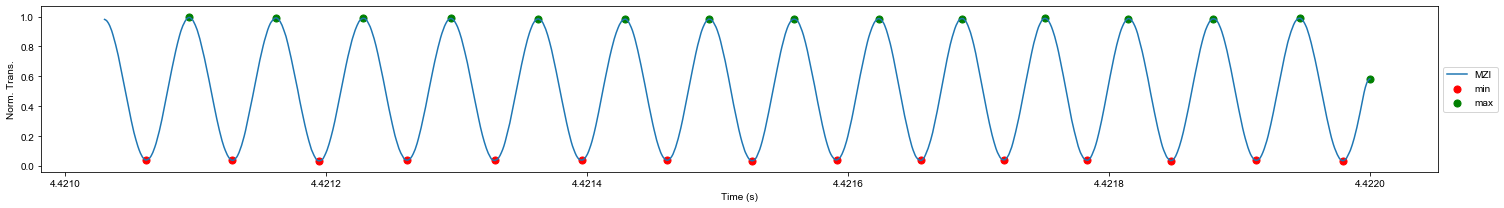

In [12]:
delta = 0.4
ind_max, maxtab, ind_min, mintab = mlt.peakdet(data_crop.mzi_s.values, delta)
ind_peaks = np.sort(np.concatenate((ind_min, ind_max), axis=0))

npeaks = 15 # Number of peaks to show in the plot
plt.figure(figsize=(21,3))
plt.plot(data_crop.time[:ind_max[npeaks]], data_crop.mzi_s[:ind_max[npeaks]], label='MZI')
plt.scatter(data_crop.time[:ind_min[npeaks]][ind_min[:npeaks]], mintab[:npeaks], s=50, c='r', label='min')
plt.scatter(data_crop.time[:ind_max[npeaks]][ind_max[:npeaks]], maxtab[:npeaks], s=50, c='g', label='max')
plt.xlabel('Time (s)')
plt.ylabel('Norm. Trans.')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

### Finding the HCN peaks to build an absolute frequency axis
Datasheet:
```bash
/home/marvyn/GDrive/marvyn.inga@gmail.com/LPD_IFGW_UNICAMP/Datasheet/HCN-Peaks-NIST.pdf
```

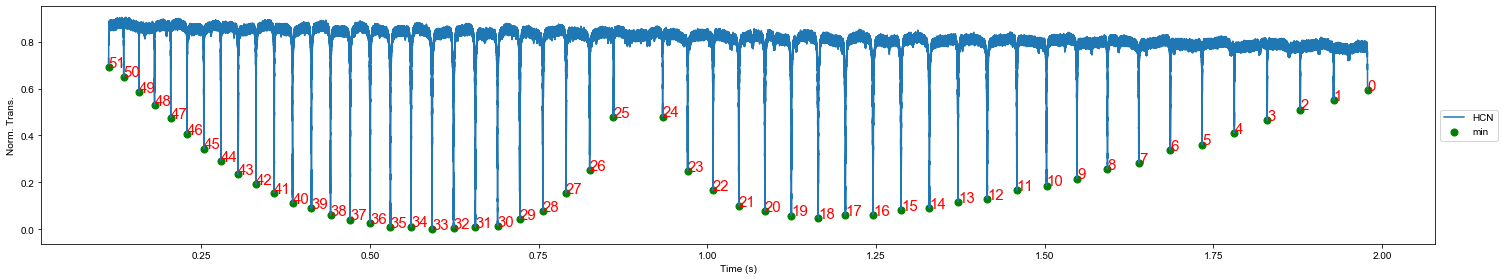

In [13]:
data_crop['hcn_n'] = (data_crop.hcn - data_crop.hcn.min())/(data_crop.hcn.max() - data_crop.hcn.min())

ind_max_hcn, maxtab_hcn, ind_min_hcn, mintab_hcn = mlt.peakdet(data_crop.hcn_n.values, 0.2)

plt.figure(figsize=(21,4))
plt.plot(data_crop.time[ind_min_hcn[0]:ind_min_hcn[-1]], data_crop.hcn_n[ind_min_hcn[0]:ind_min_hcn[-1]], label='HCN')
plt.scatter(data_crop.time[ind_min_hcn], mintab_hcn, c='g', s=50, label='min')

ax = plt.gca()
for ii in range(0,len(ind_min_hcn)):
    ax.annotate(ii, (data_crop.time[ind_min_hcn[ii]], mintab_hcn[ii]), color='r', fontsize=15)

plt.xlabel('Time (s)')
plt.ylabel('Norm. Trans.')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

### Recognizing and choosing one HCN-peak to be the central frequency
- Is recommended to use the peak 11 ($\lambda_{11}$ = 1534.972 nm) of the HCN R-Branch as the central frequency. It is approximately the center of the TUNICS laser band used in experiments. 
- The *idx_central* is the index of the nearest MZI-peak from the 11 HCN-peak.

In [14]:
peak_hcn = 36 # According to the plot above, this peak correspond to Peak 11 of the R-Branch (check in the HCN datasheet)

λ0 = 1534.972 # in nm
freq0 = 1e-3*c/λ0 # in THz
print(f'λ0 = {λ0} nm, \nν0 = {round(freq0,5)} THz')

idx_central = np.argmin(np.abs(ind_min_hcn[peak_hcn] - ind_peaks))
range_vector = (np.arange(len(ind_peaks)) - idx_central)/2 # Divided by 2 because the frequency distance between 2 MZI-peaks is equal to FSR/2

λ0 = 1534.972 nm, 
ν0 = 195.3081 THz


### Constructing the frequency ruler based on interpolation
- Considering the fiber-MZI dispersion is possible to obtain a more reliable frequency axis.
- Dispersion parameters ($D_1$, $D_2$ and $D_3$) are evaluated in the central wavelength $\lambda_0$.
- Interpolate or estimate all time-data points within the range of **[data_crop.time[ind_peaks[-1]], data_crop.time[ind_peaks[0]]]**.
- Reduce the range of data to interval before and make a copy.

In [15]:
D1_mzi = lambdify(x, D1_mzi)(λ0) # FSR for MZI in THz
D2_mzi = lambdify(x, D2_mzi)(λ0) # D2/2pi for MZI in THz
D3_mzi = lambdify(x, D3_mzi)(λ0) # D3/2pi for MZI in THz

print('MZI Parameters: \n' + cprint.CSELECTED + 'D1_mzi = {:.4g} MHz, D2_mzi = {:.3g} Hz, D3_mzi = {:.3g} μHz'.format(1e6*D1_mzi, 1e12*D2_mzi, 1e18*D3_mzi) + cprint.CEND)

freq_r = freq0 + D1_mzi*range_vector + D2_mzi/2*range_vector**2 + D3_mzi/6*range_vector**3

freq_ifunc = interpolate.interp1d(data_crop.time[ind_peaks], freq_r)

data_i = data_crop.iloc[min(ind_peaks):max(ind_peaks),:].copy()
data_i['freq'] = freq_ifunc(data_i.time)
data_i.reset_index(drop=True, inplace=True)

print('Dataframe memory usage: \n' + cprint.CSELECTED + f'{round(data_i.shape[1]*data_i.memory_usage(index=False).mean()/1e6,2)} MB' + cprint.CEND)
data_i.head()

MZI Parameters: 
D1_mzi = 137.6 MHz, D2_mzi = 0.496 Hz, D3_mzi = -3.4 μHz
Dataframe memory usage: 
1629.55 MB


time      lamb       cav       mzi       hcn  yupper_cav     cav_n  \
0  4.422000  4.745392  0.590871  0.398731  0.073754    0.589392  1.002508   
1  4.421999  4.759868  0.582014  0.398742  0.073637    0.589394  0.987478   
2  4.421999  4.793795  0.589684  0.393345  0.073374    0.589396  1.000488   
3  4.421998  4.729378  0.583548  0.385061  0.074258    0.589398  0.990075   
4  4.421998  4.737883  0.585933  0.379791  0.073258    0.589400  0.994118   

   ylower_mzi  yupper_mzi     mzi_n     mzi_s     hcn_n        freq  
0    0.263736    0.456613  0.699902  0.583393  0.552601  186.542988  
1    0.263736    0.456613  0.699956  0.582654  0.550395  186.542990  
2    0.263736    0.456613  0.671977  0.577874  0.545424  186.542991  
3    0.263736    0.456613  0.629029  0.572654  0.562118  186.542993  
4    0.263736    0.456613  0.601703  0.564186  0.543240  186.542995

### Important information about the frequency calibration
- When frequency axis was properly built, the central frequency should be equal to **freq0** (check 2 cells above).
- Calibrated frequency and wavelength bands should be compatible with Tunics laser band.

In [16]:
print('Central Wavelength = {:.3f} nm'.format(1e-3*c/data_i.freq[ind_peaks[idx_central]]))
print('Frequency Band = [{:.1f}, {:.1f}] THz'.format(data_i.freq.iloc[0], data_i.freq.iloc[-1]))
print('Wavelength Band = [{:.1f}, {:.1f}] nm'.format(1e-3*c/data_i.freq.iloc[-1], 1e-3*c/data_i.freq.iloc[0]))
print('Spectral Range = {:.1f} THz = {:.1f} nm'.format(data_i.freq.iloc[-1] - data_i.freq.iloc[0], 1e-3*c/data_i.freq.iloc[0] - 1e-3*c/data_i.freq.iloc[-1]))

Central Wavelength = 1534.972 nm
Frequency Band = [186.5, 205.4] THz
Wavelength Band = [1459.8, 1607.1] nm
Spectral Range = 18.8 THz = 147.3 nm


### Error building the frequency axis
Is possible to check the quality of the calibration comparing the wavelength/frequency of each HCN-peak with the tabulated data in datasheet.

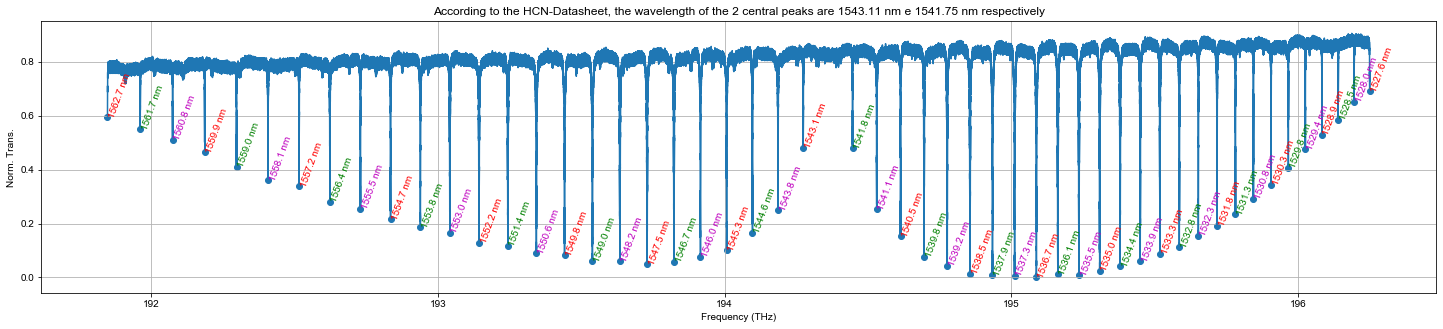

In [17]:
plt.figure(figsize=(25,5))
plt.plot(data_i.freq[ind_min_hcn[0]:ind_min_hcn[-1]], data_i.hcn_n[ind_min_hcn[0]:ind_min_hcn[-1]])
plt.scatter(data_i.freq[ind_min_hcn], mintab_hcn)
plt.title('According to the HCN-Datasheet, the wavelength of the 2 central peaks are 1543.11 nm e 1541.75 nm respectively')
colors = itertools.cycle(['r', 'g', 'm'])

ax = plt.gca()
for ii in range(0,len(ind_min_hcn)):
    ax.annotate('{:.1f} nm'.format(1e-3*c/data_i.freq[ind_min_hcn[ii]]), (data_i.freq[ind_min_hcn[ii]], mintab_hcn[ii]), color=next(colors), rotation=70)

plt.grid(True)
plt.xlabel('Frequency (THz)')
plt.ylabel('Norm. Trans.')
plt.show()

### Plotting processed data

In [18]:
data_i.hvplot(x='freq', y='cav_n', width=1500, height=250, hover=False, datashade=True)

:DynamicMap   []
   :RGB   [freq,cav_n]   (R,G,B,A)

### Saving processed data
- Only frequency, MZI and cavity data are enough to obtain information about cavity dispersion.
- Create another dataframe only containing these data can reduce the memory usage.
- The **brotli** compression option save the data using a little less space in storage disk when compared with other options.

In [19]:
data = pd.DataFrame()

data['freq'] = data_i.freq
data['mzi'] = data_i.mzi_s
data['cav'] = data_i.cav_n

data.to_parquet(fname[0:-5]+'-Processed.parq', compression='brotli')

### Restart kernel

In [20]:
%reset -f